<a href="https://colab.research.google.com/github/Khaled97Otour/ECG_Model/blob/main/ECG_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv1D, BatchNormalization,MaxPool1D, GlobalMaxPool1D
from keras.layers import TimeDistributed, GRU, Dense, Dropout, Masking, Embedding, LSTM ,Flatten
from keras.layers import Input, Conv1D, DepthwiseConv1D,GlobalMaxPool1D,\
      Dense, Concatenate, Add, ReLU, BatchNormalization, AvgPool1D,MaxPool1D,\
      GlobalAvgPool1D, Reshape, Permute, Lambda, Activation,RepeatVector
from keras import layers
from keras import models
import keras.backend as K
from keras.models import Model
import keras.backend as K
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy, matplotlib
import csv
from scipy.fft import ifft,rfft
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def Import_data(x,y):
  # read the files and build a dataset 
  # after processing the input signals
  rows = []
  rows1= []
  for row in x:
    rows.append(row)
  for row1 in y:
    rows1.append(row1)
  raw_normal_signals=np.asarray(rows)
  raw_Abnormal_signals=np.asarray(rows1)
  return raw_normal_signals,raw_Abnormal_signals


In [6]:
def signal_pre_processing(x,y):
  # in this function I use for loops to help me filtering the signals and delete the high frequnce noice
  # taking in mind the range of the signals and the length 
  # side_note: this process could be used in any code to help clean any ECG dataset 
  s1=[]
  s2=[]
  l=x.shape[0]
  ll=y.shape[0]
  for i in range(l):
    b=scipy.fft.fft (x[i])
    for i in range(188) :
      if b[i].real >=8:
        b[i]=0
      if b[i].real <=-8:
        b[i]=0
    b=scipy.fft.ifft(b)
    s1.append(b)
  for i in range(ll):
    B=scipy.fft.fft (y[i])
    for i in range(188) :
      if B[i].real >=8:
        B[i]=0
      if B[i].real <=-8:
        B[i]=0
    B=scipy.fft.ifft(B)
    s2.append(B)
  Normal_signals=np.asarray(s1)
  AbNormal_signals=np.asarray(s2)
  return Normal_signals,AbNormal_signals

In [7]:
def Do_dataset(x,y):
  # building dataset after cleaning all the signals and establish a dataframe as well as define a colume of labels.
  l=x.shape[0]
  ll=y.shape[0]
  number=[]
  signals=[]
  for i in range(l):
    signals.append(x[i])
    number.append(0)
  for i in range(ll):
    signals.append(y[i])
    number.append(1)
  numbers=np.asarray(number)
  # constructe dataset using data frame 
  my_series=pd.Series(data=signals,name='signals')
  data=pd.DataFrame(my_series)
  data['label']=numbers
  return data

In [8]:
def load_signal_label(x):
  signals = []
  label = []
  Signals_data=[]
  for i in range(len(x)):
    indexed_data = x.iloc[i]
    ff = indexed_data['signals']
    i = 0
    signals.append(indexed_data['signals'])
    label.append(indexed_data['label'])
  signals = np.asarray(signals)
  label   = np.asarray(label)
  return signals, label

In [9]:
def data_gen(x,y):
  batch_signals = []
  batch_label = []
  # steps 
  for i in range(len(x)):
    sig=x[i]
    sig = np.expand_dims(sig, axis=-1)
    batch_signals.append(sig)
    labell =y[i]
    batch_label.append(labell)
  A=np.asarray(batch_signals)
  B=np.asarray(batch_label)
  return A, B

In [10]:
def data_scaling (x):
  Signals = []
  X       = []
  for i in range(len(x)):
    for j in range (188):
      x[i][j]=(x[i][j]-x[i].min())/(x[i].max()-x[i].min())
      X.append(x[i][j])
    Signals.append(X)
  Signals = np.asarray(Signals)
  return Signals

In [11]:
def steps(x):
  Signals=[]
  for i in range(len(x)):
    X = x[i]
    X = np.expand_dims(X, axis=0)
    X = np.resize(X,[10,188])
    n=0
    Z=[]
    for j in range(10):
      step=n+10
      Y=X[j]
      for k in range(188):
        if k<=step and k>n:
          Y[k]=Y[k]
        else:
          Y[k]=0
      n=n+18
      Z.append(Y)
    Signals.append(Z)
  Signals=np.asarray(Signals)
  return Signals

In [12]:
file = open(r'/content/drive/MyDrive/Colab Notebooks/ECG Signal /ptbdb_normal.csv')
csvreader = csv.reader(file)
file1 = open(r'/content/drive/MyDrive/Colab Notebooks/ECG Signal /ptbdb_abnormal.csv')
csvreader1 = csv.reader(file1)


In [13]:
Normal,AbNormal= Import_data(csvreader,csvreader1)

In [14]:
normal,Abnormal= signal_pre_processing(Normal,AbNormal)

In [15]:
Dataset= Do_dataset(normal,Abnormal)
Signals, label= load_signal_label(Dataset)
#Signals = data_scaling(Signals)
Signals.shape 

(14552, 188)

In [16]:
Signals=steps(Signals)
xx_train_gen, yy_train_gen = data_gen(Signals, label)

In [17]:
Dataset

,signals,label
0,"[(0.8814269457646506+0j), (0.781751111585726-1...",0
1,"[(0.7626284556067051+0j), (0.5573099450743261-...",0
2,"[(0.746369916851573+0j), (0.628823060448222-1....",0
3,"[(0.9268670122267956+0j), (0.4057603518607373-...",0
4,"[(0.8985901580172332+0j), (0.7658285007792268-...",0
...,...,...
14547,"[(0.8376090676923766+0j), (0.8562004120489136+...",1
14548,"[(0.5157839059733816+0j), (0.5206110217705371-...",1
14549,"[(0.7602951799819148+0j), (0.6248058047966818-...",1
14550,"[(0.7209435549110979+0j), (0.7022499980736755-...",1


In [18]:
Signals[0].shape

(10, 188)

In [19]:
print(xx_train_gen.shape)

(14552, 10, 188, 1)


In [20]:
def action_model(shape=(10,188, 1), nbout=2):
    
  def Convnet(shape=(188,1)):
    model= Sequential()
    model.add(Conv1D(32,3,input_shape=shape,strides=1,padding='same', activation='relu'))

    model.add(MaxPool1D(pool_size=2))

    model.add(Conv1D(64,5,strides=1,padding='same', activation='relu'))
    
    model.add(MaxPool1D(pool_size=2))

    model.add(Conv1D(128,7,input_shape=shape,strides=1,padding='same', activation='relu'))
  
    model.add(MaxPool1D(pool_size=2))

    model.add(Conv1D(256,9,input_shape=shape,strides=1,padding='same', activation='relu'))

    model.add(MaxPool1D(pool_size=2))

    model.add(GlobalMaxPool1D())
    return model

  model= Sequential()

  model.add(TimeDistributed(Convnet(shape[1:]),input_shape=shape))
  model.add(LSTM(64))
  model.add(Dense(1024, activation='sigmoid'))
  model.add(BatchNormalization())

  model.add(Dense(512, activation='sigmoid'))
  model.add(BatchNormalization())

  model.add(Dense(256, activation='sigmoid'))
  model.add(BatchNormalization())

  model.add(Dense(128, activation='sigmoid'))
  model.add(BatchNormalization())

  model.add(Dense(64, activation='sigmoid'))
  model.add(BatchNormalization())

  model.add(Dense(32, activation='sigmoid'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  return model

In [21]:
signal_dim = (188,1)
steps= (10) 
classes = 2
INPUT_SHAPE= (steps,)+signal_dim
print(INPUT_SHAPE)
model = action_model(INPUT_SHAPE, 2)


(10, 188, 1)


In [22]:
from sklearn.model_selection import train_test_split
# Split the data
x_Data, x_valid, y_Data, y_valid = train_test_split(xx_train_gen, yy_train_gen, test_size=0.33, shuffle= True)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x_Data, y_Data, test_size=0.33, shuffle= True)

In [24]:
optimizer = tf.keras.optimizers.Adam()
model.compile(
    optimizer,
    'binary_crossentropy',
    metrics=['accuracy']
)
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_loss', 
                              mode = 'auto' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_loss', 
                                mode='auto', 
                                save_best_only=True, 
                                verbose = 1)

learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                                  mode = 'auto',
                                  patience = 5,
                                  factor = 0.3,
                                  min_delta = 0.00001)

callback_list = [earlystopping, checkpoint,learning_rate ]

In [25]:
print(model.summary())
history=model.fit(
    x_train,y_train,
    validation_data = (x_test,y_test),
    verbose=1,
    epochs=500,
    batch_size = 128,
    callbacks = callback_list
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 256)          363072    
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 64)                82176     
                                                                 
 dense (Dense)               (None, 1024)              66560     
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2

Text(0.5, 0, 'epoch')

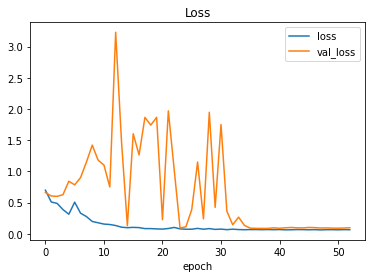

In [26]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

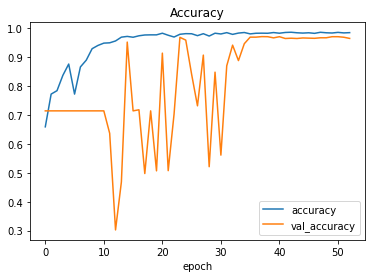

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [28]:
model.evaluate(x_valid, y_valid)

151/151 [==============================] - 1s 6ms/step - loss: 0.1075 - accuracy: 0.9650


[0.10752379149198532, 0.9650218486785889]

In [30]:
import json

# lets assume `model` is main model 
model_json = model.to_json()
with open("model_in_json_ECG.json", "w") as json_file:
    json.dump(model_json, json_file)

model.save_weights("ECG_lstm.h5")
